---
 # <center> Convex Optimization - Homework 3
 
<center> Realized By: Eya Ghamgui
<center> eya.ghamgui@telecom-paris.fr

---

## Import Librairies 

In [1]:
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
sns.set() 

## Barrier Method 

In this part, we want  to solve the centring problem: 

$$ \text{minimize} ~~t f_0(x) - \sum_{i=1}^m log(- f_i(x)) $$ 

To do this, I will implement the Newton method to solve the centring step using the backtracking line search. 

In [2]:
# The function f0 
def f0(Q, p, v) :
    return np.dot(np.dot(v.T,Q),v) + np.dot(p.T,v)

In [3]:
# Calculate the objective function 
def f (Q, p, A, b, t, v) : 
    
    fi = np.dot(A,v) - b 
    if (fi >= 0).any() : 
        return None
    else : 
        return (t * f0(Q, p, v) - np.sum(np.log(-fi)))

In [4]:
# The gradient of the objective function
def gradf (Q, p, A, b, t, v) :
    
    df = 2 * np.dot(Q,v) + p
    dfi = np.dot(-A.T , 1/(b - np.dot(A,v)))
    
    return t * df - dfi 

In [5]:
# The hessian of the objective function
def hessf (Q, p, A, b, t, v) : 
    
    ddf = 2 * Q 
    aux  = (1 /((b - np.dot(A,v))**2)).reshape(-1)
    ddfi = np.dot(np.dot(-A.T , np.diag(aux)), A)
    
    return (t * ddf - ddfi)

In [6]:
# Bachtracking function 
def backtrack (Q, p, A, b, t, v, dv) :
    
    t_new = 1  
    while True : 
        
        v_new = v + t_new *dv
        if f(Q, p, A, b, t, v_new) != None : 
            if f(Q, p, A, b, t, v_new) >= f(Q, p, A, b, t, v) + alpha * t_new * np.dot((gradf(Q, p, A, b, t, v)).T, dv):
                t_new = t_new * beta
            else: 
                break 
        else : 
            break
    
    return t_new

In [7]:
# The centering step function 
def centering_step (Q, p, A, b, t, v0, eps) : 
    
    v_list = [v0]
    v = v0
    k = 0

    while True :
        
        df = gradf(Q, p, A, b, t, v)
        ddf = hessf(Q, p, A, b, t, v)
        
        dv = - np.dot(np.linalg.inv(ddf),df)
        lambda2 = - np.dot(df.T , dv)
        
        if lambda2 / 2 <= eps : 
            break 
            
        t_new = backtrack (Q, p, A, b, t, v, dv)       
        v = v + t_new * dv 
        v_list.append(v)
        k += 1
    
    return v_list, k 

In [8]:
# The barrier method to solve QP 
def barr_method (Q, p, A, b, v0, eps) : 
    
    m = A.shape[0]   
    v = v0 
    t_new = t0
    v_list = [v0]
    num_iter = 0
  
    while (m/t_new)>= eps : 
        v, k = centering_step(Q, p, A, b, t_new, v, 1e-5)
        v = v[-1]
        v_list.append(v)
        num_iter += k
        t_new = t_new * mu 

    return (v_list , num_iter) 

## Testing part for different values of $\mu$

In [9]:
# Parameters 
n = 50
d = 100

# Random Initialization 
X, y, w = make_regression( n_samples = n , n_features = d, coef=True, random_state=42)
y = y.reshape(-1 , 1)
w = w.reshape(-1 , 1)

# Variables 
Q = 0.5*np.eye(n)
A = np.vstack((X.T , -X.T))
p = - y
b = 10 * np.ones((2*d,1))
v0 = np.zeros((n,1))

eps = 1e-3
t0 = 1
alpha  = 0.01 
beta = 0.5 
mu_list = [2, 10, 15, 30, 50, 100, 150, 200,500]

#### 1. Duality Gap

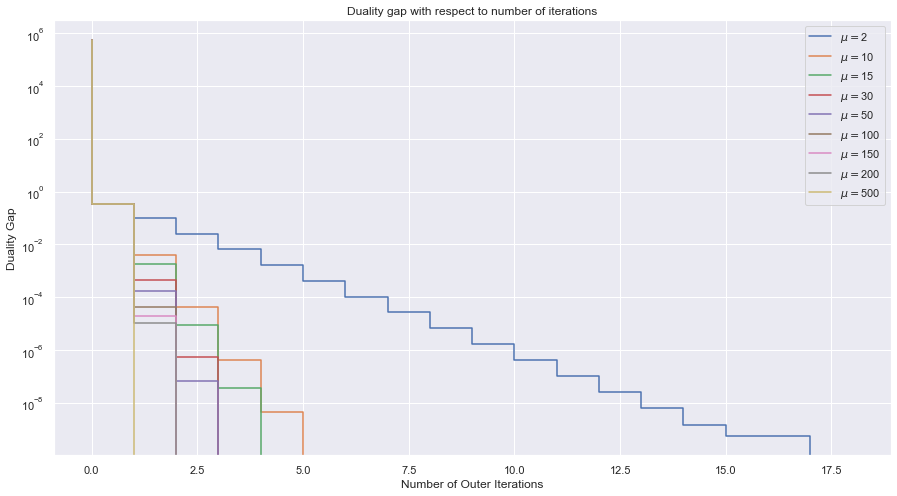

In [10]:
plt.figure(figsize=(15,8))

iter_list =[]
objective = []

for mu in mu_list : 
    
    v_list , num_iter = barr_method (Q, p, A, b, v0, eps)
    iter_list.append(num_iter)
    gap =[]
    
    for v in v_list :
        diff = f0 (Q, p, v) - f0 (Q, p, v_list[-1])
        gap.append(diff[0][0])
    
    objective.append(f0 (Q, p, v_list[-1])[0][0])
        
    itr = range(len(gap))
    plt.step(itr , gap)
    
plt.semilogy()
plt.xlabel("Number of Outer Iterations")
plt.ylabel("Duality Gap")
plt.legend(['$\mu = $' + str(x) for x in mu_list])
plt.title('Duality gap with respect to number of iterations')
plt.savefig("dual_gap")
plt.show()

#### 2. Optimal Values

In [11]:
for m in mu_list: 
    print('For mu = ',m, ' the optimal value is equal to = ', objective[mu_list.index(m)])

For mu =  2  the optimal value is equal to =  -546860.7121899601
For mu =  10  the optimal value is equal to =  -546860.7121899601
For mu =  15  the optimal value is equal to =  -546860.7121899598
For mu =  30  the optimal value is equal to =  -546860.7121899595
For mu =  50  the optimal value is equal to =  -546860.7121899601
For mu =  100  the optimal value is equal to =  -546860.7121899556
For mu =  150  the optimal value is equal to =  -546860.712189959
For mu =  200  the optimal value is equal to =  -546860.7121899598
For mu =  500  the optimal value is equal to =  -546860.7121882644


#### 3. Newton Iterations 

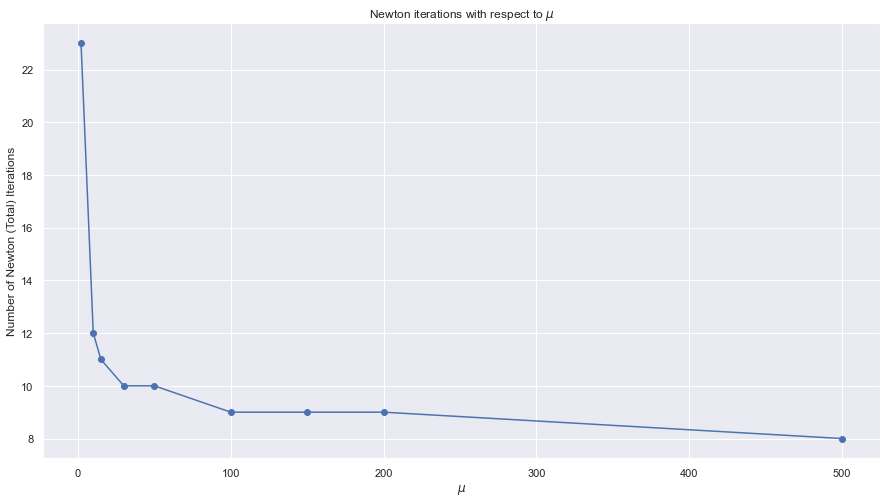

In [12]:
plt.figure(figsize=(15,8))
plt.plot(mu_list , iter_list , marker = 'o')
plt.ylabel("Number of Newton (Total) Iterations")
plt.xlabel('$\mu$')
plt.title('Newton iterations with respect to $\mu$')
plt.savefig("Newton_iter")
plt.show()

## Impact of $\mu$ on $w$

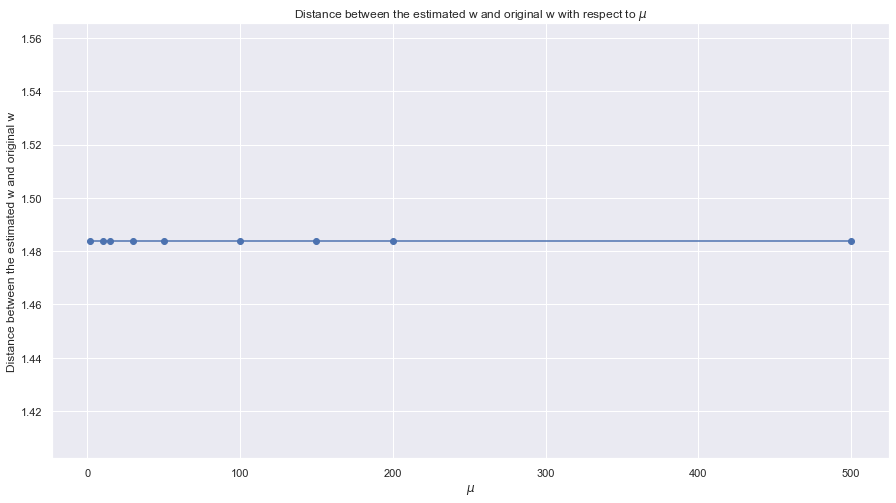

In [13]:
# Using KKT condition, we can calculate the estimated w = X^-1(y - v*)

dist = []

for m in mu_list:
    v_list , num_iter = barr_method (Q, p, A, b, v0, eps)
    
    w_est = np.dot(np.linalg.pinv(X), y - v_list[-1]) 
    w_est /= np.linalg.norm(w_est)
    w /= np.linalg.norm(w) 
    
    dist.append(np.linalg.norm(w_est - w))

plt.figure(figsize=(15,8)) 
plt.plot(mu_list, dist, marker = 'o')
plt.ylabel("Distance between the estimated w and original w")
plt.xlabel('$\mu$')
plt.title('Distance between the estimated w and original w with respect to $\mu$')
plt.savefig("dist")
plt.show()